In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment1.ipynb")

# Assignment 1: 2018 US House Elections
**PSTAT 134/234 (Winter 2023)  
Due Date: Monday, May 1st, 11:59 PM**

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## Direction and Goal

![election_prediction](include/clinton-trump-rating.png)  
[image credit](https://donsnotes.com/politics/images/clinton-trump-rating.png)

We haven't talked about predictive models, but we can still think about what makes a "good" prediction.  In this assignment, we'll focus on evaluating the quality of election predictions made by the website [fivethirtyeight.com](https://www.fivethirtyeight.com).  As one prominent example, fivethirtyeight predicted that Clinton had a 70.9% chance to win the election.  Was their model wrong?

To gain insight into questions like this, we'll focus on  [US House elections predictions from 2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/).  Their predictions are based predominantly on polling data but include other sources as well (state of the economy, overall favoriability of politic parties, etc).  

This homework is based loosely on [this article](https://projects.fivethirtyeight.com/checking-our-work/).  Please read the article before beginning the assignment.

## Question 1: Data Processing

### Read Data into Python

Numpy and Pandas is used to read in the csv file into python.

In [2]:
import pandas as pd
import numpy as np
election_data = pd.read_csv("us_house_elections.csv", low_memory=False)

Add column of zeros named `bin` to `election_data` (we will populate this column with meaningful data later) and `print` the first 10 rows of the `DataFrame` using `iloc`.

In [3]:
election_data['bin'] = 0
print(election_data.iloc[:10])

   year office state  district election_date forecast_date forecast_type  \
0  2022  House    WY       1.0    2022-11-08    2022-11-08          lite   
1  2022  House    WY       1.0    2022-11-08    2022-11-08          lite   
2  2022  House    WV       2.0    2022-11-08    2022-11-08          lite   
3  2022  House    WV       2.0    2022-11-08    2022-11-08          lite   
4  2022  House    WV       1.0    2022-11-08    2022-11-08          lite   
5  2022  House    WV       1.0    2022-11-08    2022-11-08          lite   
6  2022  House    WI       8.0    2022-11-08    2022-11-08          lite   
7  2022  House    WI       7.0    2022-11-08    2022-11-08          lite   
8  2022  House    WI       7.0    2022-11-08    2022-11-08          lite   
9  2022  House    WI       6.0    2022-11-08    2022-11-08          lite   

  party            candidate  projected_voteshare  actual_voteshare   probwin  \
0     D    Lynnette GreyBull             30.15680         24.367980  0.000825   
1

Fivethirtyeight has three different prediction models: `lite`, `classic` and `deluxe`, which roughly incorporate an increasing number of assumptions.  In this assignment lets focus on evaluting the quality of the `classic` predictions.  You can read more about how the prediction models work [here](https://fivethirtyeight.com/methodology/how-fivethirtyeights-house-and-senate-models-work/).

Fivethirtyeight continuously updated their predictions as more polling data became available for each of the races.  Let's focus on the predictions a few months before the election, on August 11th, and on the morning of election day, November 6th.  

### Question 1a: Subset Data

<!--
BEGIN QUESTION
name: q1a
manual: false
points: 5
-->

Create a new pandas dataframe called `election_sub` by filtering to include only rows in which the `forecast_type` is "classic", and the date of the foreceast (`forecast_date`) is 8/11 or 11/6. 

Using `query` method seems well-suited.  Note you can make two (or more) calls to `query` by chaining calls to `query` like this: `election_data.query(...).query(...)`. Output of one query will be used as an input to the second query.

In [4]:
# Fill-in ...
election_sub = election_data.query("forecast_type == 'classic'").query("forecast_date == '2018-08-11' | forecast_date == '2018-11-06'")

In [5]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b: Filtering Data

In previous question, data was subset for two forcast dates: 2018-11-06 and 2018-08-11. Presumably, there _should be_ two rows (predictions) for each candidate; however, you will see that some candidates are missing one of the two predictions and not all name entries are valid.

Using Pandas, remove any NaN names and any candidate that does not have two predictions.

Finally, overwrite `election_sub` with the filtered data.

There are different ways of doing this. I found the following functions useful:

* [`pandas.DataFrame.isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html)
* [`pandas.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [`pandas.core.groupby.DataFrameGroupBy.filter`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.filter.html)
* [`pandas.DataFrame.shape`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html)

When using the documentation, make sure to use the correct version. You can check by running `pd.__version__`.

<!--
BEGIN QUESTION
name: q1b
manual: false
points: 3
-->

In [6]:
# Fill-in ... and ###some task###
election_sub = election_sub[~election_sub['candidate'].isnull()].groupby(['office', 'state', 'district', 'candidate']).filter(lambda x: len(x) == 2)

In [7]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Transform Data

<!--
BEGIN QUESTION
name: q1c
manual: false
points: 3
-->

We want to check whether events predicted by 538 to occur with probability _close to_ X% actually occured about X% of the time.  To do this, we have to define _close_.

First, we'll define the `cut_points` as 20 equally spaced numbers between 0 and 1 using `np.linspace`.  Then we'll group the predicted probabilities into the `19` equally spaced bins determined by those cut points.  Define the bin for each observation using the `pd.cut` function on the `probwin` variable.  Then, assign the result to column `bin` of `election_sub`. Use `include_lowest=True` when calling `pd.cut`.

_Note: Can you spot the strange behavior of `include_lowest=True`? [Despite the output, `pd.cut` seems to work correctly](https://github.com/pandas-dev/pandas/issues/23164#issuecomment-510700455)_

In [8]:
cut_points = np.linspace(0, 1, num=20)
election_sub['bin'] = pd.cut(election_sub['probwin'], bins=cut_points, include_lowest=True)

In [9]:
grader.check("q1c")

q1c results: All test cases passed!

## Question 2: Looking for Insights

### Question 2a: Calculate Change in Support

Let's see if we can find the candidates whose standings change the most between August 11 and November 6: one with largest improvement and another with largest decrease in win-probability. First, use the `agg` function calculate the difference.

Following functions have been useful for me:

* [`numpy.diff`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html)
* [`pandas.DataFrame.sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)
* [`pandas.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [`pandas.DataFrame.agg`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html): especially, [different functions to columns](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#applying-different-functions-to-dataframe-columns) 

Save the resulting DataFrame from `agg()` to a variable, `probwin_change`. 

<!--
BEGIN QUESTION
name: q2a
manual: false
points: 5
-->

In [10]:
probwin_change = election_sub.groupby(['candidate']).agg({'probwin': lambda x: np.diff(x)[0]})
probwin_change = probwin_change.sort_values(by='probwin', ascending=False)


In [11]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b: Looking for Largest Changes

Now, save the name of the candidates to string variables `rising_candidate` (largest increase) and `falling_candidate` (largest decrease).

* [`pandas.DataFrmae.idxmax`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html)
* [`pandas.DataFrmae.idxmin`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html)

<!--
BEGIN QUESTION
name: q2b
manual: false
points: 3
-->

In [12]:
rising_candidate = probwin_change['probwin'].idxmax()
falling_candidate = probwin_change['probwin'].idxmin()
print(rising_candidate)
print(falling_candidate)

Kevin Yoder
Sharice Davids


In [13]:
grader.check("q2b")

q2b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2c: Verify Outcome

Did the candidate win or lose the election? Verify with election outcome.
<!--
BEGIN QUESTION
name: q2c
manual: true
points: 5
-->

***ANSWER***

Kevin Yoder, the rising candidate won the election. Sharice Davids hte falling candidate did not win the election. This alligns with the results we had from earlier.

<!-- END QUESTION -->



## Prediction vs Actual Outcomes

<!-- BEGIN QUESTION -->

### Question 3a: Prediction Histogram

Make a histogram showing the predicted win probabilities _on the morning of the election._  Again, restrict yourself to only the `classic` predictions.

<!--
BEGIN QUESTION
name: q3a
manual: true
points: 5
-->

<Axes: >

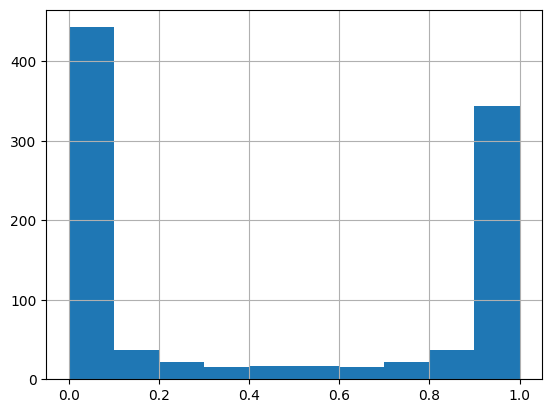

In [14]:
election_data[(election_data['forecast_type'] == 'classic') & (election_data['forecast_date'] == '2018-11-06')]['probwin'].hist()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Prediction difficulty 

Are most house elections easy to forecast or hard to forecast? State your reasoning.

<!--
BEGIN QUESTION
name: q3b
manual: true
points: 5
-->

***ANSWER***

Based on the histogranm the house predicitons are easy to predict. The highest predicted win probabilities are closer to 0 or 1 which means the model 

<!-- END QUESTION -->

### Question 4a: Compute Actual Outcomes

Now we've grouped the observations into a discrete set of bins according to the predicted probability, `probwin`.  Within each bin, we now want to compute the actual fraction of times the candidates won.

If 538 did a good job, it will be close to the predited probabilities.  You'll need to use the `groupby` function to compute the mean of `probwin_outcome` (1 is a win and 0 is a loss) within each bin. Once again you can use `agg` method here.  

Save the fraction of actual wins in each bin in a list called `fraction_outcome`.

<!--
BEGIN QUESTION
name: q4a
manual: false
points: 5
-->

In [15]:
fraction_outcome = election_sub.groupby('bin').agg({"probwin_outcome":'mean'})

In [16]:
grader.check("q4a")

q4a results: All test cases passed!

### Question 4b: Preparing to Present Results

<!--
BEGIN QUESTION
name: q4b
manual: false
points: 5
-->

For this problem we'll make a plot of the predicted probabilities and actual fraction of wins in each bin.  We've already computed the actual fraction of wins; all that remains is to plot it against the predicted value assocaited with each bin.

For the predicted value in each bin, using the midpoint of the bin would make sense.  Compute the midpoints of each bin from `cut_points`.

In [17]:
midpoints = np.convolve(cut_points, [0.5, 0.5], mode='valid')

In [18]:
grader.check("q4b")

q4b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 4c: Visualize Results

<!--
BEGIN QUESTION
name: q4c
manual: true 
points: 5
-->

Now make a scatterplot using `midpoints` as the x variable and `fraction_outcome` as the y variable.  Draw a dashed line from `[0,0]` to `[1,1]` to mark the line y=x.  

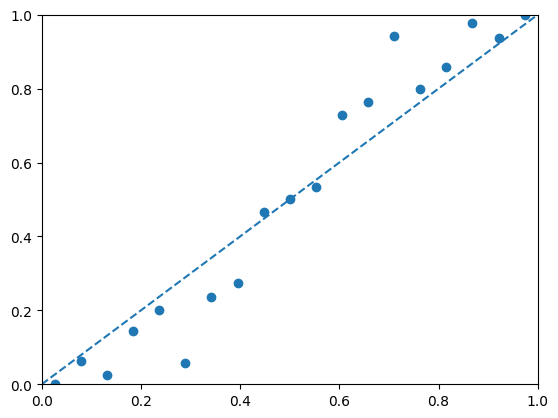

In [24]:
import matplotlib.pyplot as plt
x = midpoints
y = fraction_outcome
plt.scatter(x, y)
plt.plot([0, 1], [0, 1], '--')
plt.axis(xmin = 0, xmax = 1, ymin = 0, ymax = 1)
plt.show()

<!-- END QUESTION -->



## Quantifying Uncertainty

### Question 5a: Model-based Error Estimation

If you did things correctly, it should look like fivethirtyeight has done "pretty" well with their forecasts: the actual fraction of wins tracks closely with the predicted number.

But how do we decide what's "good enough"? Consider this example: I correctly predict that a coin is fair (e.g. that it has a 50% chance of heads, 50% chance of tails).  But if I flip it 100 times, I can be pretty sure it won't come up heads exactly 50 times.  The fact that heads didn't come up exactly 50 times doesn't make my prediction incorrect.

To assess how reasonable the predictions are, I need to quantify the uncertainty in my estimate.  It's reasonable to assume that within each bin, $k$, the observed number of wins, $Y_k \sim \text{Binomial}\,(n_k, p_k)$, where $n_k$ is the number of elections and $p_k$ is the predicted win probability in bin $k$.

Classical results tell us that the obseved fraction of wins in bin $k$, $\hat p = \frac{Y_k}{n_k}$ has variance $\operatorname{Var}\left(\hat p_k\right) = \frac{p_k (1-p_k)}{n_k} \approx \frac{\hat p_k(1- \hat p_k)}{n_k}$.  The standard deviation of the Binomial proportion then is $\hat \sigma_k \approx \sqrt{\frac{\hat p_k(1- \hat p_k)}{n_k}}$.  

If we use the [normal approximation to generate a confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval), then the 95% interval has the form $\hat p_k \pm 1.96 \hat \sigma_k$.

Create a new "aggregated" dataframe named `election_agg`.  Take `election_sub`, group by `bin` and compute both the average of the `probwin_outcome` (`mean`) and the number of observations in each bin (`count`) using the `agg` function.  Call this new data frame, `election_agg`.

THen, use the `mean` and `count` columns of `election_agg` to create a new column of `election_agg` titled `err`, which stores $1.96 \times \hat \sigma_k$ in each bin $k$.

<!--
BEGIN QUESTION
name: q5a
manual: false
points: 3
-->

In [25]:
election_agg = election_sub.groupby('bin')['probwin_outcome'].agg(['mean', 'count'])
election_agg['err'] = 1.96 * np.sqrt( election_agg['mean'] * (1-election_agg['mean']) / (election_agg['count']) )

In [26]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5b: Visualize Error Bars 1

Use `plt.errorbar` to create a new plot with error bars associated with the actual fraction of wins in each bin.  Again add a dashed y=x line.  Set the argument `fmt='.'` to create a scatterplot with errorbars.

<!--
BEGIN QUESTION
name: q5b
manual: true
points: 5
-->

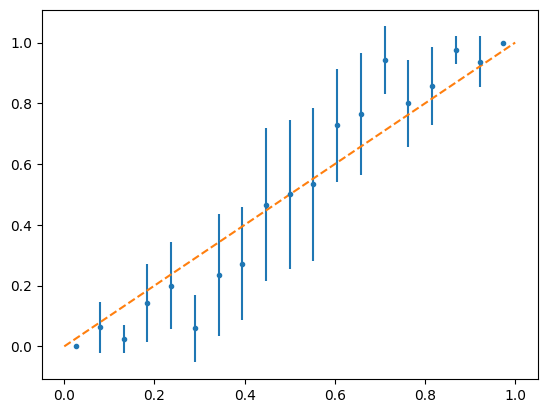

In [27]:
# Plotting code below
plt.errorbar(midpoints, election_agg['mean'].values, yerr=election_agg['err'].values, fmt='.')
plt.plot([0, 1], [0, 1], '--')

<!-- END QUESTION -->

### Question 5c: Computing Coverage

If our intervals were true 95% confidence intervals, then we would expect about 95% of them to cover the midpoint of the bin (i.e. overlap with the y=x line).

What fraction of the 95% confidence intervals cover the bin midpoint?  Create a variable, `upper`, to be the `mean` + `err` and another, `lower`, to be `mean` - `err` (both `upper` and `lower` should pandas series). Next, compute `frac_covering` as the fraction of midpoints between `lower` and `upper`. 

<!--
BEGIN QUESTION
name: q5c
manual: false
points: 5
-->

In [28]:
upper = election_agg['mean'] + election_agg['err']
lower = election_agg['mean'] - election_agg['err']

frac_covering = np.mean((midpoints <= upper) & (midpoints >= lower))

In [29]:
grader.check("q5c")

q5c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5d: Understanding Confidence Intervals

Are the 95% confidence intervals generally larger or smaller for more confident predictions (e.g. the predictions closer to 0 or 1).  What are the factors that determine the length of the confidence intervals?

<!--
BEGIN QUESTION
name: q5d
manual: true
points: 5
-->

***ANSWER***

The confidence intervall is small than for the predicitions. This is because the variance is inderectly proportional to the varaiance, so the smaller sample size will make the confidence larger. 

<!-- END QUESTION -->



_Intentionally Blank_

### (PSTAT 234) Question 5e: Empirical Uncertainty Estimation

Model-based error bars were calculated by assuming that election outcomes are Binomial random variables. However, we can also estimate the error bars from resampling the data. This can be useful if we do not have a good distributional about the election outcomes, for example.

Write a function named `bootstrap_data_means` that can take a data frame, say `data_in`, as input. Suppose `data_in` has `n` rows. Inside `bootstrap_data_means` function, you will

* [`numpy.random.Generator.choice`](https://docs.scipy.org/doc/numpy/reference/random/generated/numpy.random.Generator.choice.html?highlight=random%20choice#numpy.random.Generator.choice): Select `n`-rows of `data_in` at random _with replacement_, creating a pseudo-dataset
* `agg`: Group by each `bin`, compute probabilities of success for each pseudo-dataset as you have done


Then, run the function `bootstrap_data_means` function 100 times, storing the resulting 100 DataFrames in a list. Then, create a data frame `bootstrap_election_100_agg` using `pandas.concat`:

* Python list comprehension: https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions
* [`pandas.concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html): Concatenate many DataFrames together.  
    Especially, the example, _Combine two DataFrame objects with identical columns._, in https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html could be helpful.

<!--
BEGIN QUESTION
name: q5e
manual: false
points: 5
-->

In [ ]:
def bootstrap_data_means(data_in):
    
    from numpy.random import choice
    
    n = len(data_in)
    
    # randomly sample row indices with replacement
    indx = ...
    # compute probabilities of success
    bootstrap_means = ...
    
    return(bootstrap_means)

bootstrap_election_100_agg = ...

In [ ]:
grader.check("q5e")

<!-- BEGIN QUESTION -->

### (PSTAT 234) Question 5f. Visualize Error Bars 2

By now, we have a distribution of success probabilities saved in `bootstrap_election_agg`. We can compute empirical error bars from 2.5% and 97.5% quantiles. Write function named `bootstrap_error_bars` that can be used to calculate the following columns:

* `mean`: mean of probabilities of success
* `err_low`: low point of the error bars
* `err_high`: high point of the error bars

Funtion `bootstrap_error_bars` is to be called by using `bootstrap_election_100_agg.apply(bootstrap_error_bars, ...)`.

<!--
BEGIN QUESTION
name: q5f
manual: true
points: 5
-->

In [ ]:
def bootstrap_error_bars(x):
    out = pd.Series([x.mean(), x.mean()-x.quantile(0.025), x.quantile(0.975)-x.mean()], 
                    index=['mean', 'err_low', 'err_high'])
    return(out)

<!-- END QUESTION -->



Use [`pandas.DataFrame.apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) and `bootstrap_error_bars` functions to calculate and visualize the error bars.

In addition, to the figure code used in 5b, add horizontal lines at 0 and 1.

In [ ]:
# calculate error bars
bootstrap_election_agg = ...

plt.figure(figsize=(10, 10))
plt.errorbar(midpoints, 
             election_agg['mean'].values, 
             yerr=election_agg['err'].values, 
             fmt='.', elinewidth=3, ms=20, 
             capsize=5, capthick=3)
plt.plot([0, 1], [0, 1], '--')
plt.plot([0, 1], [1, 1], ':r')
plt.plot([0, 1], [0, 0], ':r')
plt.xlabel("Predicted Win Probability")
plt.ylabel("Observed Win Probability")
# Overlay empirical error bars on the same plot. Use the following 
# visual attributes: 
# ..., fmt='.r', elinewidth=1, ms=10, ecolor='red', capsize=5, ...
# Also, yerr can accept asymmetric errorbars (see the documentation for usage)
...
plt.show()

<!-- BEGIN QUESTION -->

### (PSTAT 234) Question 5g: Interpreting the Results

Are the 95% confidence intervals generally larger or smaller for more confident predictions (e.g. the predictions closer to 0 or 1).  What are the factors that determine the length of the error bars?

Compare and contrast model-based error bars and empirically obtained error bars. What are the advantages and disadvantages of these two approaches?

<!--
BEGIN QUESTION
name: q5g
manual: true
points: 5
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



_Intentionally Blank_

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()